In [1]:
%%html
<!-- definir quelques styles custom pour l'ensemble du notebook -->
<style>    
    @import url("css/custom_styles.css")
</style>

<center>
    <h1>
    Algorithmes d’apprentissage non supervisé<br>
    </h1>
    MovieLens - Système de recommendations de films<br>
    <br>
    <b>Jean-Francois Gagnon</b><br>
    <b>Michèle de La Sablonnière</b><br>
    <br>
    420-A58<br>
    <br>
</center>

# Introduction
    
Nous avons choisi la base de données [MovieLens Small](https://tinyurl.com/bdhmcfht). Elle décrit les notations des utilisateurs de MovieLens; un service de recommandations de films. Elle a été préalablement traité afin d'extraire les informations intéressantes pour un système de suggestions par *clusterisation* et règles d'associations. Les données pré-traitées se trouvent dans 2 fichiers. 

<br>**movies_pretraitement.csv**

Ce fichier contient les métadonnées pertinentes à 1 film. Chaque ligne a ce format:

<div class="indentation">
<div class="fixblock"> movieId, imdbId, title, year, year_category, year_boxcox_std, rating_mode, genres, genres_tfidf_*</div>

|Attribut|<center>Description</center>|
|:-|:---|
|movieId| Identifiant du film dans cette base de données.|
|imdbId| Identifiant du film dans [Internet Movie Database](http://www.imdb.com).|
|title| Titre du film. Peut contenir l'année de parution.|
|year| Année de parution du film.|
|year_category| **year** catégorisé. La base de données a 3 modalités.|
|year_boxcox_std| **year** transformé par BoxCox et StandardScaler.|
|rating_mode| Nombre d'étoiles attribuées avec une granularité de $\frac{1}{2}$. Entre [0.5 et 5] |
|genres| Liste de mots séparés par un 'pipe' (\|). La base de données a 18 modalités. |
|genres_tfidf_*| **genres** encodé selon TF-IDF. Ici l'étoile représente toutes les modalités de **genres**. |
</div>

<br>**ratings_pretraitement.csv**

Ce fichier contient les métadonnées de notations de chaque utilisateur. Chaque ligne a ce format:

<div class="indentation">
<div class="fixblock">userId, films*</div>

|Attribut|<center>Description</center>|
|:-|:---|
|userId| Identifiant de l'utilisateur.|
|films*| Notation de l'utilisateur pour un film. Ici l'étoile représente 1 colonne par film. |
</div>

<br>

Nous allons d'abord valider les prétraitements. Par la suite, dans un but de restreindre la portée du projet, nous allons faire une *clusterization* de 2 représentations de genres (**genres** et **genres_tfidf\***) et examiner 2 méthodes de réduction de dimensions pour chaque représentation. Finalement nous allons examiner les règles d'associations avec **ratings_pretraitement.csv**.

In [2]:
#
# imports utilitaires
#

%matplotlib inline

import base64
import cv2
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from fanalysis.base import Base
from fanalysis.mca import MCA
from mlxtend.frequent_patterns import apriori, association_rules
from scipy.stats import chi2_contingency
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances
from wordcloud import WordCloud


#
# imports faisant partie de nos propres modules
#

import helpers as hlp
import helpers.Clustering as clstr
import helpers.jupyter as jup

# Lecteure des données

In [3]:
#
# parametres configurant nos traitemens
#
configs = hlp.get_configs("config_overrides.json")

# imdbId doit etre garde en string (leading 0)
movies_df = pd.read_csv("dataset/movies_pretraitement.csv", dtype={"imdbId": str})

print("Movies", movies_df.shape)
print("Head")
display(movies_df.head().round(2))
clstr.show_types(movies_df)

Movies (9460, 26)
Head


,movieId,imdbId,title,year,year_category,year_boxcox_std,rating_mode,genres,genres_tfidf_Action,genres_tfidf_Adventure,...,genres_tfidf_Fantasy,genres_tfidf_Film-Noir,genres_tfidf_Horror,genres_tfidf_Musical,genres_tfidf_Mystery,genres_tfidf_Romance,genres_tfidf_Sci-Fi,genres_tfidf_Thriller,genres_tfidf_War,genres_tfidf_Western
0,1,0114709,Toy Story (1995),1995,"[1975, 2001]",-0.19,4.0,Children|Adventure|Animation|Comedy|Fantasy,0.0,0.41,...,0.48,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
1,2,0113497,Jumanji (1995),1995,"[1975, 2001]",-0.19,4.0,Fantasy|Children|Adventure,0.0,0.51,...,0.59,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
2,3,0113228,Grumpier Old Men (1995),1995,"[1975, 2001]",-0.19,3.0,Romance|Comedy,0.0,0.00,...,0.00,0.0,0.0,0.0,0.0,0.82,0.0,0.0,0.0,0.0
3,4,0114885,Waiting to Exhale (1995),1995,"[1975, 2001]",-0.19,3.0,Drama|Romance|Comedy,0.0,0.00,...,0.00,0.0,0.0,0.0,0.0,0.72,0.0,0.0,0.0,0.0
4,5,0113041,Father of the Bride Part II (1995),1995,"[1975, 2001]",-0.19,3.0,Comedy,0.0,0.00,...,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0


Types


,movieId,imdbId,title,year,year_category,year_boxcox_std,rating_mode,genres,genres_tfidf_Action,genres_tfidf_Adventure,...,genres_tfidf_Fantasy,genres_tfidf_Film-Noir,genres_tfidf_Horror,genres_tfidf_Musical,genres_tfidf_Mystery,genres_tfidf_Romance,genres_tfidf_Sci-Fi,genres_tfidf_Thriller,genres_tfidf_War,genres_tfidf_Western
Type,int64,object,object,int64,object,float64,float64,object,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


* 9460 individus 
* 26 variables (inclus les identifiants, elles correspondent bien à la description)
* **title**, **year_category** et **genres** sont de type qualitatif. Les autres variables sont de type quantitatif. Noter que **rating_mode** représente bien une variable qualitative par nature mais est gardée quantitative pour faciliter certaines manipulations.

# Doublons et valeurs manquantes

In [4]:
#
# validation doublons et valeurs manquantes 
#
print("Avant retrait doublons:", movies_df.shape)
movies_df.drop_duplicates(inplace=True)
print("Après retrait doublons:", movies_df.shape)

clstr.show_na(movies_df);

Avant retrait doublons: (9460, 26)
Après retrait doublons: (9460, 26)
Valeur manquante 0 (0.0%)


Aucun doublon et aucune valeur manquante. Nous allons vérifier les modalités des variables qualitatives.

In [5]:
#
# Verification des modalites (rating_mode est egalement inclu pour valider
# s'il correspond bien a sa description)
#
def get_mods(values, name=""):
    if isinstance(values, pd.Series):
        series = pd.Series(values.unique())
        series.name = values.name
    else:
        series = pd.Series(values)
        series.name = name
    
    return series.to_frame()

genres_ohe_df = movies_df.genres.str.get_dummies(sep=configs.dataset.genre_splitter)
genres_mods = get_mods(genres_ohe_df.columns, name="genres")

html_ = jup.horizontify(get_mods(movies_df.year_category),
                        get_mods(movies_df.rating_mode),
                        genres_mods)
print("Modalités")
jup.display_html(html_)

Modalités


,year_category
0,"[1975, 2001]"
1,"[1902, 1974]"
2,"[2002, 2018]"
,rating_mode
0,4.0
1,3.0
2,5.0
3,2.0
4,4.5
5,3.5


# Distributions - variables quantitatives

Stats générales - variables quantitatives


,count,mean,std,min,25%,50%,75%,max
year,9460.0,1994.64,18.38,1902.00,1988.00,1999.00,2008.00,2018.00
year_boxcox_std,9460.0,-0.00,1.00,-2.68,-0.61,0.08,0.79,1.78
rating_mode,9460.0,3.48,0.97,0.50,3.00,3.50,4.00,5.00
genres_tfidf_Action,9460.0,0.11,0.23,0.00,0.00,0.00,0.00,1.00
genres_tfidf_Adventure,9460.0,0.07,0.20,0.00,0.00,0.00,0.00,1.00
genres_tfidf_Animation,9460.0,0.04,0.16,0.00,0.00,0.00,0.00,1.00
genres_tfidf_Children,9460.0,0.04,0.16,0.00,0.00,0.00,0.00,1.00
genres_tfidf_Comedy,9460.0,0.24,0.34,0.00,0.00,0.00,0.47,1.00
genres_tfidf_Crime,9460.0,0.08,0.23,0.00,0.00,0.00,0.00,1.00
genres_tfidf_Documentary,9460.0,0.04,0.20,0.00,0.00,0.00,0.00,1.00



Distributions - variables quantitatives


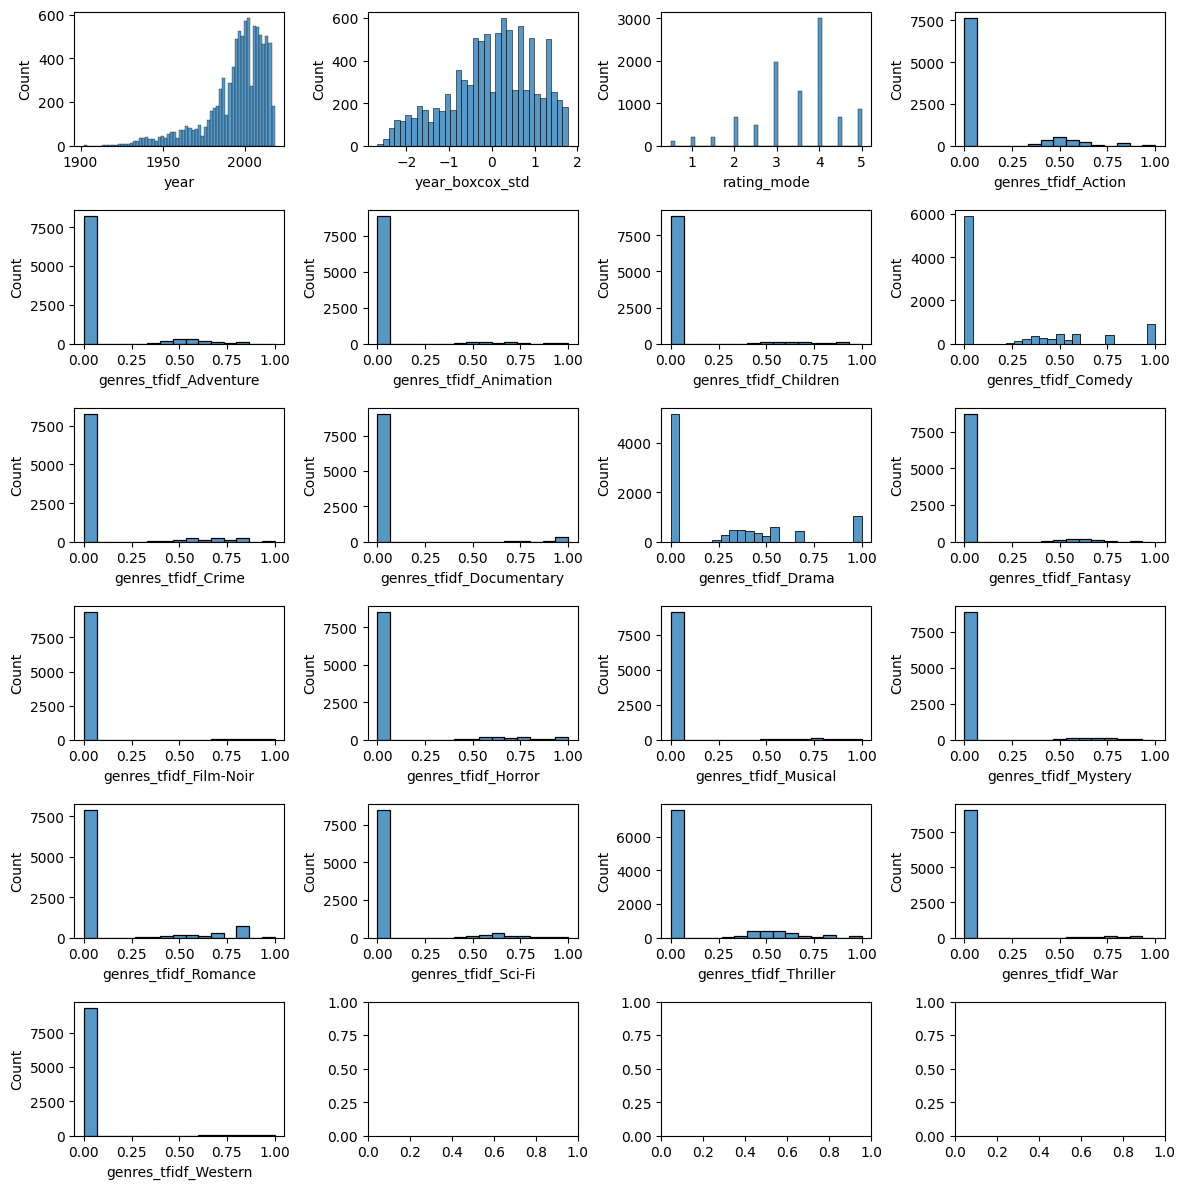

In [6]:
# on enleve movieId, imdbId et title
quant_df = movies_df.iloc[:, 3:].select_dtypes(exclude="object")

print("Stats générales - variables quantitatives")
display(quant_df.describe().T.round(2))
print()
print("Distributions - variables quantitatives")
clstr.show_distributions(quant_df, num_cols=4, figsize=(12, 12))

* **year** très allongée (queue à gauche)
* **year_boxcox_std** très près d'une distribution standard. Les statistiques générales nous montrent bien $\mu=0$ et $\sigma=1$. 
* **rating_mode**, bien qu'étant quantitative, montre bien sa nature qualitative.
* **genres_tfidf\*** ont des distributions très éparses (beaucoup de 0). Plus de détails dans les prochaines cellules.

# Valeurs aberrantes et *outliers* - variables quantitatives

IQR outliers par variable, eta: 1.5


,year,year_boxcox_std,rating_mode,genres_tfidf_Action,genres_tfidf_Adventure,genres_tfidf_Animation,genres_tfidf_Children,genres_tfidf_Comedy,genres_tfidf_Crime,genres_tfidf_Documentary,...,genres_tfidf_Fantasy,genres_tfidf_Film-Noir,genres_tfidf_Horror,genres_tfidf_Musical,genres_tfidf_Mystery,genres_tfidf_Romance,genres_tfidf_Sci-Fi,genres_tfidf_Thriller,genres_tfidf_War,genres_tfidf_Western
Count,562.0,0.0,310.0,1818.0,1239.0,573.0,626.0,0.0,1189.0,428.0,...,758.0,85.0,933.0,334.0,569.0,1562.0,964.0,1871.0,375.0,165.0
%,5.9,0.0,3.3,19.2,13.1,6.1,6.6,0.0,12.6,4.5,...,8.0,0.9,9.9,3.5,6.0,16.5,10.2,19.8,4.0,1.7



IQR outliers 7309 (77.3%), eta: 1.5

Outliers boxplots, eta: 1.5


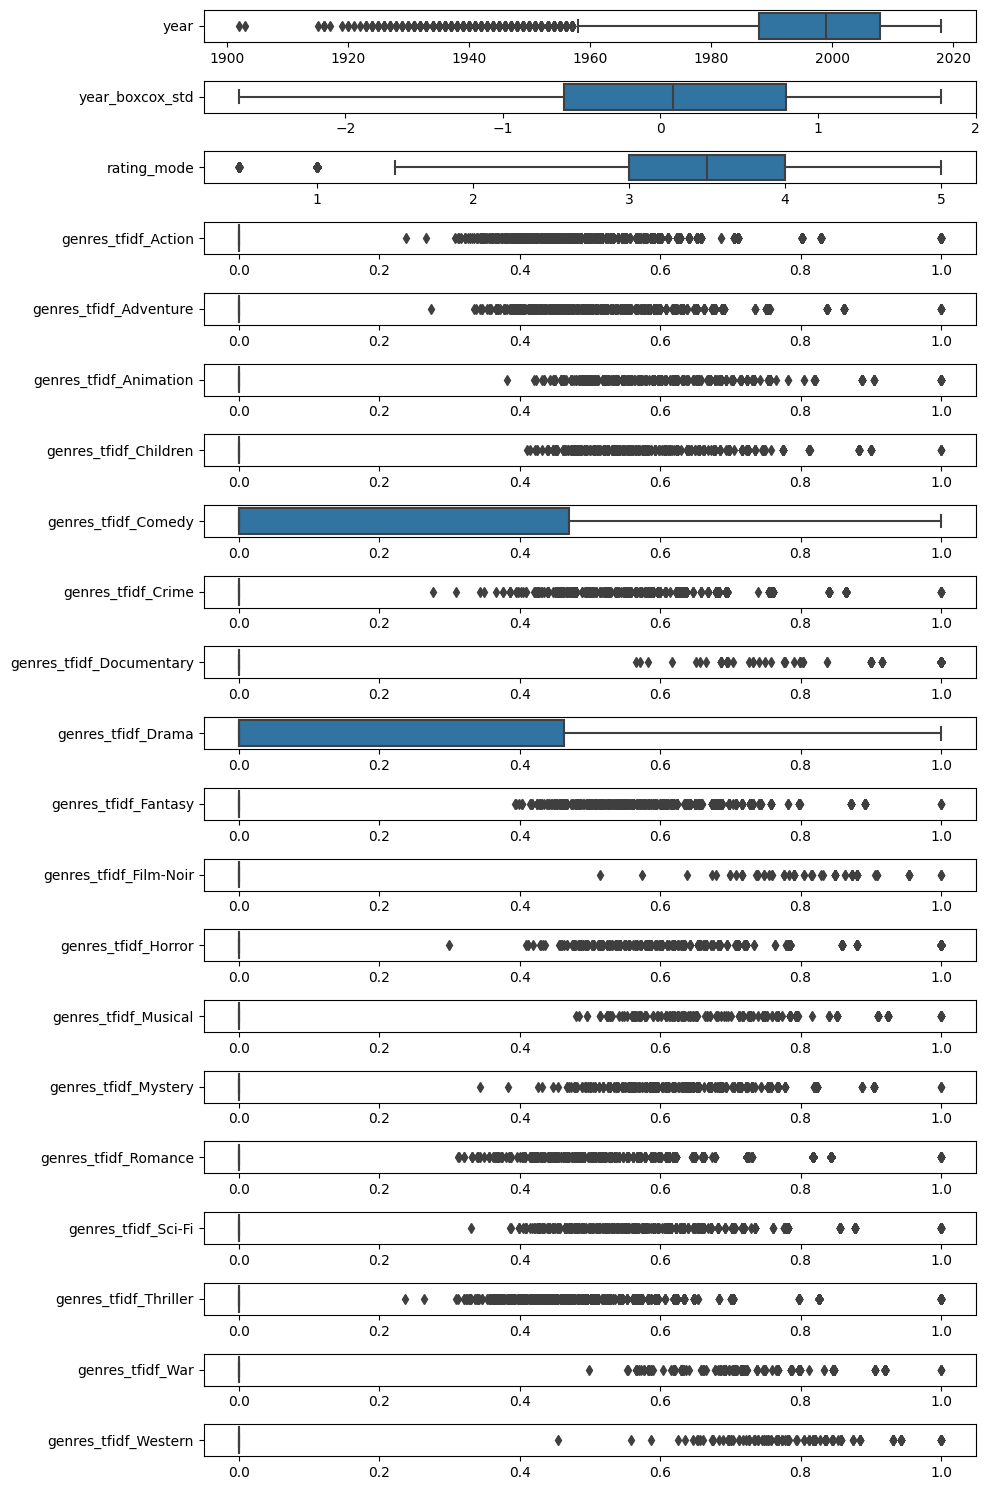

In [7]:
clstr.show_outliers_iqr(quant_df, 
                        eta=1.5,
                        boxlists=[[c] for c in quant_df.columns],
                        figsize=(10, 15));

* **year** a beaucoup d'outliers mais **year_boxcox_std** les ramène sous contrôle.
* **rating_mode** ne possède pas d'outliers à notre avis. 0.5 et 1 sont des valeurs légitimes et les distributions montrées plus haut montrent qu'il y en a très peu.
* **genres_tfidf\*** ne possède pas d'outliers à notre avis de part sa nature éparse. Les 0 marquent l'absence du genre dans certains films. Les 1 marquent quant à eux la présence d'un seul genre dans les films. Nous pensons qu'il est plus pertinent d'utiliser **genres_tfidf\*** à part et non en conjonction avec d'autres variables.

# Distributions - variables qualitatives

Distributions - variables qualitatives


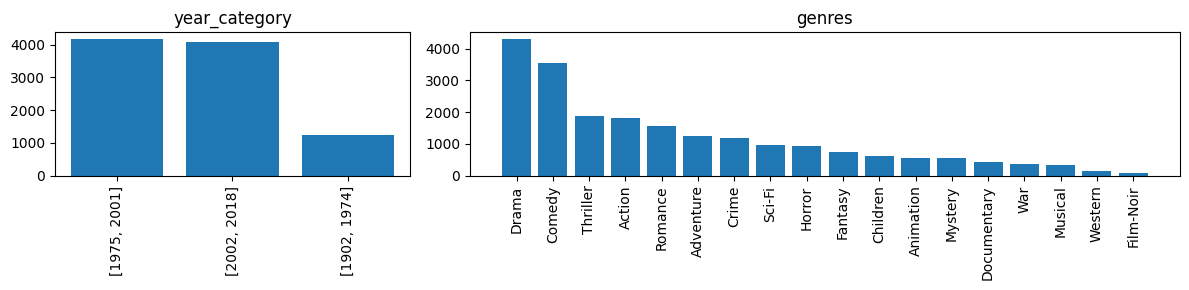

In [8]:
year_category_count = movies_df.year_category.value_counts()
genres_count = genres_ohe_df.sum(axis=0)
genres_count.sort_values(ascending=False, inplace=True)

print("Distributions - variables qualitatives")

_, axes = plt.subplots(1, 
                       2, 
                       width_ratios=[1, 2],
                       figsize=(12, 3))
axes[0].bar(year_category_count.index, year_category_count)
axes[0].tick_params(axis="x", labelrotation=90)
axes[0].set_title("year_category")

axes[1].bar(genres_count.index, genres_count)
axes[1].tick_params(axis="x", labelrotation=90)
axes[1].set_title("genres")
             
plt.tight_layout()
plt.show()

* **year_category** est très bien balancé si on ne tient pas compte de [1902, 1974]
* **gernes** a une forte proportion dans les modalités Drama et Comedy

# Corrélation

In [9]:
#
# utilitaires pour calculer chi2 (correlation avec variables qualitatives)
#
def genres_contingency(b, data, genres_modalites):
    """
    Utilitaire pour calculer la table de contingence sachant que genres est implique
    Pandas.crosstab() ne fonctionne pas avec genres
    """
    def _genres_crit(data, modality):
        return data.str.contains(fr"\b{modality}\b", case=True, regex=True)
    
    def _default_crit(data, modality):
        return data == modality
    
    if b == "genres":
        other_crit_ = _genres_crit
        other = data.genres
        other_modalities = genres_modalites
    else:
        other_crit_ = _default_crit
        other = data[b]
        other_modalities = other.unique()
    
    ct = pd.DataFrame(0, 
                      index=genres_modalites, 
                      columns=other_modalities)

    for m0 in genres_modalites:
        genres_crit = _genres_crit(data.genres, m0)
        
        for m1 in other_modalities:
            other_crit = other_crit_(other, m1)
            ct.loc[m0, m1] = np.count_nonzero(genres_crit & other_crit)
        
    return ct

def chi2(a, b, df, genres_modalites):
    """
    Encapsule le calcul de chi2 pour tenir compte de genres
    """
    if a == "genres":
        contingency = genres_contingency(b, df, genres_modalites)
    elif b == "genres":
        contingency = genres_contingency(a, df, genres_modalites).T
    else:
        contingency = pd.crosstab(df[a], df[b])
        
    chi2_, pvalue, _, _ = chi2_contingency(contingency)
    return chi2_, pvalue

def chi2_analysis(data, chi2_columns, genres_modalites):
    """
    Encapsule analyse chi2. Assumer que chi2_columns ne contient que 
    des variables qualitatives.
    """
    chi2_df = pd.DataFrame(np.nan, 
                           index=chi2_columns, 
                           columns=chi2_columns)
    chi2_pvalue_df = pd.DataFrame(np.nan, 
                                  index=chi2_columns, 
                                  columns=chi2_columns)

    for c0 in chi2_columns:
        for c1 in chi2_columns:
            prev = chi2_df.loc[c1, c0]
            if math.isnan(prev):
                prev, prev_pvalue = chi2(c0, 
                                         c1, 
                                         data,
                                         genres_modalites)
            else:
                prev_pvalue = chi2_pvalue_df.loc[c1, c0]

            chi2_df.loc[c0, c1] = prev
            chi2_pvalue_df.loc[c0, c1] = prev_pvalue

    chi2_styler = jup.caption_df(chi2_df.style, r"$\chi^2$", caption_bold=False)
    pvalue_styler = jup.caption_df(chi2_pvalue_df.style, "$p_{value}$", caption_bold=False)
    corr_html = jup.horizontify(chi2_styler, pvalue_styler)

    print("Analyse indépendance de:", chi2_columns)
    jup.display_html(corr_html)

In [10]:
chi2_analysis(movies_df,
              ["year_category", "rating_mode", "genres"], 
              genres_mods.genres)

Analyse indépendance de: ['year_category', 'rating_mode', 'genres']


,year_category,rating_mode,genres
year_category,18920.000000,849.911482,934.048473
rating_mode,849.911482,85140.000000,801.501340
genres,934.048473,801.501340,134711.974950
,year_category,rating_mode,genres
year_category,0.000000,0.000000,0.000000
rating_mode,0.000000,0.000000,0.000000
genres,0.000000,0.000000,0.000000


On voit que $p_{value}$ est < 0.05. On rejète l'hypothèse nulle (indépendance). Les variables sont donc dépendantes. On assume par conséquent que clustering peut avoir un certain sens.

Corrélation genres tfidf


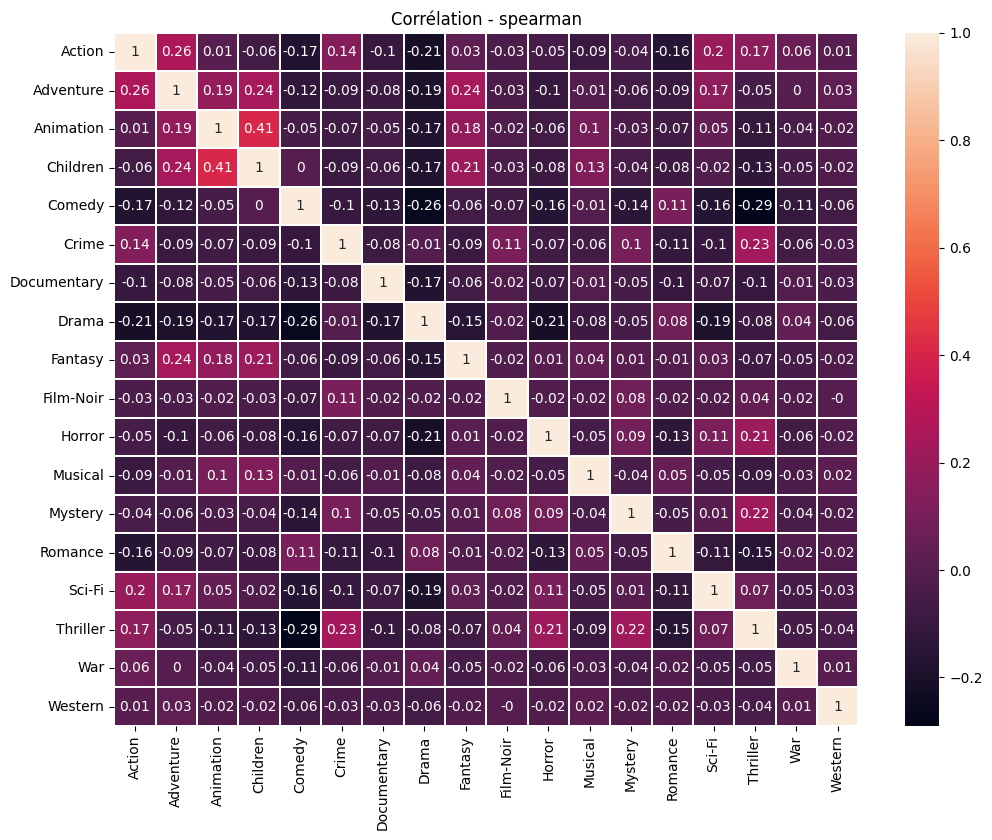

In [11]:
genres_tfidf_cols = movies_df.columns.str.contains("genres_tfidf_")
genres_tfidf_cols = movies_df.columns[genres_tfidf_cols]
genres_tfidf_df = movies_df[genres_tfidf_cols].copy()
genres_tfidf_df.columns = [c.replace("genres_tfidf_", "") for c in genres_tfidf_cols]

print("Corrélation genres tfidf")
clstr.show_correlation(genres_tfidf_df,
                       method="spearman", 
                       figsize=(12, 9))

La corrélation selon Spearman a été utilisé pour éliminer l'effet des 0. On n'observe aucune corrélation à toute fin pratique (majorités des valeurs < |0.2|) même si certaines modalités semblent exhiber un lien entre elles (Children et Animation).

On pourrait croire que la réduction de dimension ne serait pas utilile mais, encore une fois, noter la présence de beaucoup de 0 dans les distributions. Nous allons donc valider plus loin dans le notebook ce constat.

Nous allons diminuer la quantité de données afin d'alléger le temps d'itération. Ceci peut de toute évidance biaser les résultats mais nous croyons que la bonne quantité de données que nous avons contrebalance.

In [12]:
#
# diminuer la quantite de donnes a traiter par souci de temps d'iteration
#
movies_original_df = movies_df
genres_ohe_original_df = genres_ohe_df
genres_tfidf_original_df = genres_tfidf_df

In [13]:
SAMPLING_FRAC = 0.5

movies_df = movies_original_df.sample(frac=SAMPLING_FRAC, random_state=42)
genres_ohe_df = genres_ohe_original_df.loc[movies_df.index]
genres_tfidf_df = genres_tfidf_original_df.loc[movies_df.index]

print("Avant resampling:", movies_original_df.shape)
print("Apres resampling:", movies_df.shape)

Avant resampling: (9460, 26)
Apres resampling: (4730, 26)


# Réduction de dimensions et clustering
## genres ACM

Genres se représente bien avec un encodage one hot. Une analyse en composante multiple (ACM) se prête donc à la réduction de dimensions.

In [14]:
#
# l'encodage de genres ne peut se faire par fanalysis
# fanalysis ne permet pas non plus fournir notre propre encodage
# donc, ajouter ces classes pour faire un pont dans le manque de fonctionalite
#
class MCA_from_dummies(Base):
    def __init__(self, n_components=None, row_labels=None, var_labels=None, stats=True):
        Base.__init__(self, n_components, row_labels, None, stats)
        self.var_labels = var_labels
        
    def prefit(self, X, X_dummies):
        # Set columns prefixes
        self.n_vars_ = X.shape[1]
        self.prefixes_ = self.prefixes_ = [str(x) + "_" for x in self.var_labels]
        self.col_labels_short_temp_ = [x.split("_")[-1] for x in X_dummies.columns]
        self.col_labels_temp_ = X_dummies.columns
                
        # Dummy variables creation
        self.n_categories_ = X_dummies.shape[1]
    
    def fit(self, X_dummies, y=None):
        # Fit a Factorial Analysis to the dummy variables table
        self.r_ = np.sum(X_dummies, axis=1).reshape(-1, 1)
        Base.fit(self, X_dummies, y=None)
        
        # Adjustment of the number of components
        n_eigen = self.n_categories_ - self.n_vars_
        if (self.n_components_ > n_eigen):
            self.n_components_ = n_eigen
            self.eig_ = self.eig_[:, :self.n_components_]
            self.row_coord_ = self.row_coord_[:, :self.n_components_]
            self.col_coord_ = self.col_coord_[:, :self.n_components_]
            if self.stats:
                self.row_contrib_ = self.row_contrib_[:, :self.n_components_]
                self.col_contrib_ = self.col_contrib_[:, :self.n_components_]
                self.row_cos2_ = self.row_cos2_[:, :self.n_components_]
                self.col_cos2_ = self.col_cos2_[:, :self.n_components_]

        # Set col_labels_short_
        self.col_labels_short_ = self.col_labels_short_temp_
        
        # Set col_labels_
        self.col_labels_ = self.col_labels_temp_        
        
        self.model_ = "mca"
        
        return self
                        
def acm_init(data, n_components, data_dummies=None):
    if data_dummies is None:
        acm = MCA(n_components=n_components,
                  row_labels=data.index,
                  var_labels=data.columns)
        acm.fit(data.to_numpy())
    else:
        acm = MCA_from_dummies(n_components=n_components,
                               row_labels=data.index,
                               var_labels=data.columns)
        
        acm.prefit(data, data_dummies)        
        acm.fit(data_dummies.to_numpy())
    
    return acm

def acm_analysis(data, data_dummies=None, figsize=(4, 2.5)):
    """
    Le threshold est ~60% sur cumul var. expliquee
    """
    acm = acm_init(data, None, data_dummies=data_dummies)

    threshold = 1 / acm.n_vars_
    eig_vals = acm.eig_[0]
    eig_th = eig_vals[eig_vals > threshold]

    print("Valeurs propres:")
    print(acm.eig_[0].round(4))
    print()
    print(f"Valeurs propres > {round(threshold, 4)} (1 / p):")
    print(eig_th.round(4))
    print()
    print("Variance expliquee %:")
    print(acm.eig_[1].round(1))
    print()
    print("Variance expliquee cumul. %:")
    print(acm.eig_[2].round(1))
    print()

    num_eigval = len(acm.eig_[0])

    plt.figure(figsize=figsize)
    plt.plot(range(1, num_eigval + 1), acm.eig_[0], marker=".")
    plt.grid(True)
    plt.xlabel("# axe factoriel")
    plt.ylabel("Valeur propre")
    plt.show()

Valeurs propres:
[0.8973 0.6271 0.5912 0.4917 0.4565 0.4291 0.4072 0.3631 0.3464 0.3391
 0.2879 0.2786 0.2644 0.2216 0.2075 0.2024 0.1676]

Valeurs propres > 1.0 (1 / p):
[]

Variance expliquee %:
[13.6  9.5  9.   7.5  6.9  6.5  6.2  5.5  5.3  5.2  4.4  4.2  4.   3.4
  3.2  3.1  2.5]

Variance expliquee cumul. %:
[ 13.6  23.2  32.2  39.6  46.6  53.1  59.3  64.8  70.1  75.2  79.6  83.8
  87.9  91.2  94.4  97.5 100. ]



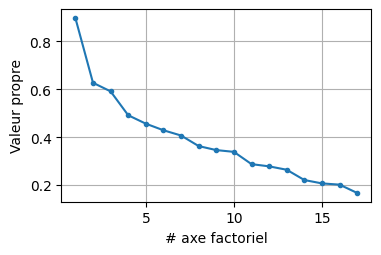

In [15]:
cluster_data_df = movies_df[["genres"]]
cluster_data_ohe_df = genres_ohe_df

acm_analysis(cluster_data_df, data_dummies=cluster_data_ohe_df)

La règle de Kaiser adaptée à l'ACM ne fonctionne pas ici (aucune valeur propre $\ge$ 1/1, p=1). Le graphe montre plusieurs coudes/plateaux (2, 7 et 10 axes factoriels). La variance expliquée cumulative nous permet de choisir 10 axes (~75% variance expliquée).

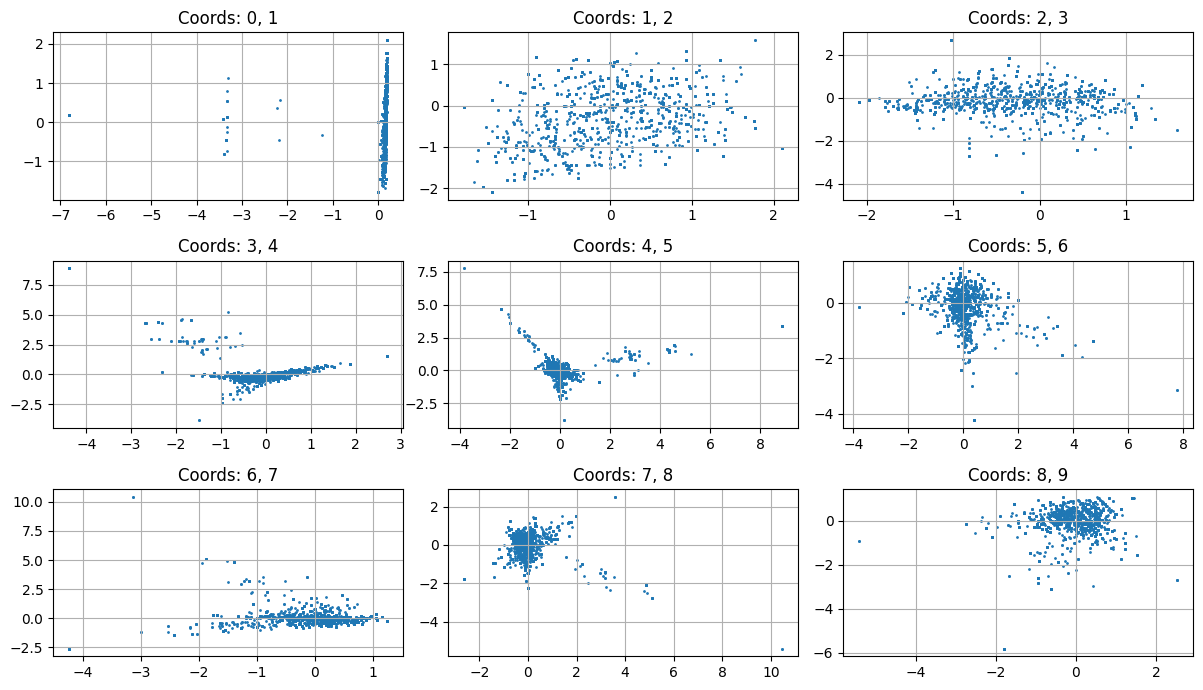

In [16]:
acm_ = acm_init(cluster_data_df, 10, data_dummies=cluster_data_ohe_df)

jup.display_html("<b>genres ACM</b> - Visualisation dimensions (non exhaustif)")
clstr.scatter_multiplot(acm_.row_coord_, num_cols=3, figsize=(12, 7), marker_size=1)

On remarque certaines structures qui se détachent ce qui laisse présager que le *clustering* est possible. Notez que les structures ne sont pas globluaires et non consistantes à travers les dimensions. Nous suspectons que KMeams ne sera pas plus efficace que la classification ascendante hiérarchique (CAH). Dans le même ordre d'idée, la densité des points ne laisse pas présager que DBSCAN soit supérieur non plus.

## genres ACM - CAH

In [ ]:
#
# etape longue (~40s) sans feedback visuel; soyez patient
#
clstr.cah_analysis(acm_.row_coord_, figsize=(12, 3))

On remarque un faible coude à 11 clusters.

In [ ]:
#
# fonctions utlitaires pour analyser contenu des clusters
#
def clusters_ohe_agg(group):
    return group.sum(axis=0)

def topmost_genres(group, count):
    group_no_zero = group[group > 0]

    # negatif pour avoir argsort() decroissant ET respecter ordre dans group
    group_no_zero = -group_no_zero
        
    topmost = group_no_zero.argsort()[:count]
    topmost = group_no_zero.index[topmost].to_list()
    topmost = "<br>".join(topmost)
    
    return pd.Series({f"{count} topmost genres": topmost})

def topmost_movies(group, labels, count):
    cluster_crit = labels == group.name
    movies = movies_df[cluster_crit] \
                .sort_values(by=["rating_mode", "year"], ascending=[False, False]) \
                .head(count)
    
    def _imdb_link(movie):
        return f"<a href='{configs.web_scraping.imdb_url}{movie.imdbId}'>{movie.title}</a>"
    
    links = movies.apply(_imdb_link, axis=1)
    links = "<br>".join(links)
    return pd.Series({f"{count} topmost movies": links})

def word_clouds(cluster):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        
        cluster_no_zero = cluster[cluster > 0]
        wc = WordCloud(width=300, height=100).generate_from_frequencies(cluster_no_zero)
        
    return pd.Series({"word_cloud": wc.to_array()})
    
def image_to_html(img):
    _, img = cv2.imencode(".png", img)
    return f"<img src='data:image/png;base64,{base64.b64encode(img).decode()}'>"
    
def clusters_analysis(ohe_df, 
                      labels, 
                      show_clusters_agg=False, 
                      head_count=0,
                      genres_count=5,
                      movies_count=8):
    clusters_agg_df = ohe_df.groupby(labels).agg(clusters_ohe_agg)
    if show_clusters_agg:
        display(clusters_agg_df)

    topmost_genres_df = clusters_agg_df.apply(topmost_genres, 
                                              axis=1, 
                                              count=genres_count)
    word_clouds_df = clusters_agg_df.apply(word_clouds, axis=1)
    topmost_movies_df = clusters_agg_df.apply(topmost_movies,
                                              axis=1, 
                                              labels=labels,
                                              count=movies_count)
    
    clusters_df = pd.concat([topmost_genres_df, 
                             word_clouds_df,
                             topmost_movies_df], axis=1)
    clusters_df.index.name = "cluster"
    
    if head_count > 0:
        clusters_df = clusters_df.head(head_count)

    html_ = clusters_df.to_html(formatters={"word_cloud": image_to_html}, escape=False)
    jup.display_html(html_)

In [ ]:
cah_ = clstr.cah_init(acm_.row_coord_, 11)

jup.display_html("<b>genres ACM</b> - Visualisation dimensions (non exhaustif) CAH")
clstr.scatter_multiplot(acm_.row_coord_, 
                        num_cols=3, 
                        figsize=(12, 7), 
                        marker_size=1, 
                        labels=cah_.labels_)

jup.display_html("<b>genres ACM</b> - Analyse clusters CAH\n")
clstr.clusters_analysis(acm_.row_coord_, cah_.labels_)
clusters_analysis(cluster_data_ohe_df, cah_.labels_)

La visualisation par graphe suggère que les *clusters* sont plutôt mal définis; long et peu compacte. Le score Davies Bouldin élevé ainsi que les scores silhouette petits (en général plus petit que 0.5 sauf pour quelques clusters) corroborent ce constat. Par contre, en regardant le *clustering* à travers les données d'origines, on peut remarquer une séparation tout de même logique. L'examen détaillé montre:
* Le cluster 5 manque de précision.
* Le cluster 6 nous apparait un peu trop englobant et contient cetains éléments non reliés aux comédies musicales.
* La présence de Batman: Year One dans le cluster 8; sérié télévisée pour enfant plus appropriée dans le cluster 10.

En général, 11 clusters nous apparait un peu petit pour la quantité de données présente.

## genres ACM - KMeans

In [ ]:
#
# etape longue (~20 secondes) sans feedback visuel; soyez patient
#
clstr.kmeans_analysis(acm_.row_coord_, 
                      clusters_range=range(2, 60),
                      n_init=5, # pour accelerer le traitement
                      figsize=(12, 3))

Le score silhouette va systématiquement en augmentant. Nous devons donc utiliser la méthode du coude avec l'inertie (wss) pour déterminer un nombre raisonable de *clusters*. Nous estimons que la zone du coude se situe entre 11 et 16 *clusters*. Nous en prenons donc 16; un peu plus que CAH et score silhouette maximale.

In [ ]:
kmeans_ = clstr.kmeans_init(acm_.row_coord_, 16)

jup.display_html("<b>genres ACM</b> - Visualisation dimensions (non exhaustif) KMeans")
clstr.scatter_multiplot(acm_.row_coord_, 
                        num_cols=3, 
                        figsize=(12, 7), 
                        marker_size=1, 
                        labels=kmeans_.labels_)

jup.display_html("<b>genres ACM</b> - Analyse clusters KMeans\n")
clstr.clusters_analysis(acm_.row_coord_, kmeans_.labels_)
clusters_analysis(cluster_data_ohe_df, kmeans_.labels_)

La visualisation par graphe suggère que les *clusters* sont un peu mieux que CAH sans être excelent. Le score Davies Bouldin un peu plus petit ainsi que les scores silhouette un peu plus grands en général corroborent ce constat. En regardant le *clustering* à travers les données d'origines, on peut remarquer une séparation tout de même logique. L'examen détaillé montre:
* Le cluster 0, 2 et 6 semblent se chevaucher dans leurs thèmes.
* Le cluster 1 semble avoir quelques suggestions hors sujet avec Tokyo Tribe (musical).
* La présence de Batman: Year One dans le cluster 3; sérié télévisée pour enfant plus appropriée dans le cluster 9.
* La présence de Near Dark dans le cluster 7; horror plus approprié dans le cluster 15

## genres ACM - DBSCAN

In [ ]:
clstr.dbscan_eps_analysis(acm_.row_coord_, 
                          n_neighbors=3,
                          ylim=(-1e-1, 1.2))

In [ ]:
#
# etape longue (~40 secondes) sans feedback visuel; soyez patient
#
eps_, min_samples_ = clstr.dbscan_parameters_analysis(acm_.row_coord_, 
                                                      eps_range=np.arange(1e-6, 0.5, 0.05),
                                                      min_samples_range=range(3, 10))
dbscan_ = clstr.dbscan_init(acm_.row_coord_, eps_, min_samples_)

jup.display_html("<b>genres ACM</b> - Visualisation dimensions (non exhaustif) DBSCAN")
clstr.scatter_multiplot(acm_.row_coord_, 
                        num_cols=3, 
                        figsize=(12, 7), 
                        marker_size=1, 
                        labels=dbscan_.labels_)

jup.display_html("<b>genres ACM</b> - Analyse clusters DBSCAN (HEAD)\n")
clstr.clusters_analysis(acm_.row_coord_, dbscan_.labels_)

clusters_analysis(cluster_data_ohe_df, dbscan_.labels_, head_count=10)

La visualisation par graphe suggère que les clusters sont plutôt mal définis; longs et peu compactes. Le score Davies Bouldin est élevé ainsi que les scores silhouette (en général > 0.7). Les scores silhouette s'expliquent par la grande quantité de *clusters*; plus il y en a, plus les clusters vont coller aux données. 223 nous apparait tout de même excessif. L'examen du *clustering* à travers les données d'origines montre quelques incohérences (*cluster* 3 avec Antichrist (dama horror), *cluster* 2 avec Presumed Innocent (mystery, thriller)) mais le tout reste quand même logique.

Nous allons comparer la *clusterization* précédante avec une autre représentation de **genres**. A savoir **genres_tfidf\***. Une analyse en composante principale (PCA) sera utilisée pour réduire la dimentionalité étant donné que cette variable est quantitative. Nous avons quelques réserves à ce propos. D'une part, la PCA demande de centrer chacune des  variables. Hors tf-idf requière l'ensemble de celles-ci pour chaque individu; c'est un vecteur. Changer chaque composante indépendemant semble donc contre nature. D'autre aprt, la grande présence de 0 biaise le centrage. Nous allons donc utiliser **genres_tfidf\*** directement sans autre transformation.

## genres_tfidf* PCA

In [ ]:
pca_std_df = pd.DataFrame(genres_tfidf_df, 
                          index=genres_tfidf_df.index,
                          columns=genres_tfidf_df.columns)

clstr.pca_analysis(pca_std_df)

La règle de Kaiser ne permet pas de déterminer le nombre d'axes factoriel à choisir. Le coude suggère 3 axes pour une variance expliquée de \~42%. Cependant, nous gardons 6 axes pour avoir une variance expiquée supérieurs à 60% (\~65%).

In [ ]:
pca_ = clstr.pca_init(pca_std_df, 6)

jup.display_html("<b>genres_tfidf PCA</b> - Visualisation dimensions (non exhaustif)")
clstr.scatter_multiplot(pca_.row_coord_, num_cols=3, figsize=(12, 5), marker_size=1)

On remarque certaines structures qui se détachent nettement ce qui laisse présager le *clustering* est possible. Les formes non globulaires suggèrent que KMeans ne sera pas énormément plus efficace que CAH mais elles sont tout de même plus nettes que CAH. La densité des points laisse présager que DBSCAN pourrait être un bon choix.

## genres_tfidf* PCA - CAH

In [ ]:
#
# etape tres longue (~40 secondes) sans feedback visuel; soyez patient
#
clstr.cah_analysis(pca_.row_coord_, figsize=(12, 3))

On remarque un coude à 7 *clusters*.

In [ ]:
cah_ = clstr.cah_init(pca_.row_coord_, 7)

jup.display_html("<b>genres_tfidf PCA</b> - Visualisation "
                 "dimensions (non exhaustif) CAH")
clstr.scatter_multiplot(pca_.row_coord_, 
                        num_cols=3, 
                        figsize=(12, 5), 
                        marker_size=1, 
                        labels=cah_.labels_)

jup.display_html("<b>genres_tfidf PCA</b> - Analyse clusters CAH\n")
clstr.clusters_analysis(pca_.row_coord_, cah_.labels_)
clusters_analysis(cluster_data_ohe_df, cah_.labels_)

Le score Davies Bouldin est grand et les scores silhouette sont relativement petits (autour de 0.4 en général) ce qui suggère des *clusters* plus ou moins bien déinis. Ceci corrobore la visualisation des dimensions où on remarque des zones mais sans frontière franche. 

Examiner les *clusters* dans les données d'origines semble suggérer qu'ils forment une division logique. Les *cluster* 0 et 5 sont très peu discriminants par contre. 

## genres_tfidf* PCA - KMeans

In [ ]:
#
# etape longue (~20 secondes) sans feedback visuel; soyez patient
#
clstr.kmeans_analysis(pca_.row_coord_, 
                      clusters_range=range(2, 60),
                      n_init=5, # pour accelerer le traitement
                      figsize=(12, 3))

Le score silhouette va systématiquement en augmentant. Nous devons donc utiliser la méthode du coude avec l'inertie (wss) pour déterminer un nombre raisonable de *clusters*. Nous estimons que la zone du coude se situe entre 7 et 10 *clusters*. Nous en prenons 10; permier point du coude où se trouve un plateau dans le score silhouette.

In [ ]:
kmeans_ = clstr.kmeans_init(pca_.row_coord_, 10)

jup.display_html("<b>genres_tfidf PCA</b> - Visualisation dimensions (non exhaustif) KMeans")
clstr.scatter_multiplot(pca_.row_coord_, 
                        num_cols=3, 
                        figsize=(12, 5), 
                        marker_size=1, 
                        labels=kmeans_.labels_)

jup.display_html("<b>genres_tfidf PCA</b> - Analyse clusters KMeans\n")
clstr.clusters_analysis(pca_.row_coord_, kmeans_.labels_)
clusters_analysis(cluster_data_ohe_df, kmeans_.labels_)

La visualisation par graphe suggère que les clusters sont un peu mieux que CAH sans être excelent. Le score Davies Bouldin un peu plus petit ainsi que les scores silhouette un peu plus grands en général corroborent ce constat. En regardant le clustering à travers les données d'origines, on peut remarquer une séparation tout de même logique. L'examen détaillé montre:
* La présence de Tokyo Tribe (musical) dans le *cluster* 2 semble hors thème
* Le *cluster* 7 semble un peu trop englobant avec romance et war.


## genres_tfidf* PCA - DBSCAN

In [ ]:
clstr.dbscan_eps_analysis(pca_.row_coord_, 
                          n_neighbors=3,
                          ylim=(-1e-2, 0.3))

In [ ]:
#
# etape longue (~40 secondes) sans feedback visuel; soyez patient
#
eps_, min_samples_ = clstr.dbscan_parameters_analysis(pca_.row_coord_, 
                                                  eps_range=np.arange(1e-6, 0.2, 0.05),
                                                  min_samples_range=range(3, 10))
dbscan_ = clstr.dbscan_init(pca_.row_coord_, eps_, min_samples_)

jup.display_html("<b>genres_tfidf PCA </b> - Visualisation "
                 "dimensions (non exhaustif) DBSCAN")
clstr.scatter_multiplot(pca_.row_coord_, 
                        num_cols=3, 
                        figsize=(12, 5), 
                        marker_size=1, 
                        labels=dbscan_.labels_)

jup.display_html("<b>genres_tfidf PCA </b> - Analyse clusters DBSCAN (HEAD)\n")
clstr.clusters_analysis(pca_.row_coord_, dbscan_.labels_)

clusters_analysis(cluster_data_ohe_df, dbscan_.labels_, head_count=10)

Grand score Davies Bouldin. Très grand score silhouette en général (> 0.6) qui peut être expliqué par la grande quantité de *clusters* (colle trop aux données). La visualisation ne montre pas de zones bien définies. L'examen des *clusters* dans les données d'origines montre que ceux-ci sont très peu discriminant. Par exemple *clusters* 0, 1 et 2 ou *clusters* 7 et 8. 

Notre prochaine étape est d'analyser une autre technique de réduction de dimension. En effet, la forte présence de 0 n'est pas sans influencer les résultats précédents. Nous allons essayer [TruncatedSVD](https://tinyurl.com/578bxnnt).

## genres TruncatedSVD

In [ ]:
#
# utilitaires pour analyser TruncatedSVD
#
def truncated_svd_init(data, n_components):
    return TruncatedSVD(n_components=n_components).fit(data)

def truncated_svd_analysis(data, figsize=(4, 2.5)):
    model = truncated_svd_init(data, data.shape[1])
    coords = model.transform(data)
    
    explained_variance_ratio_ = np.cumsum(model.explained_variance_ratio_)

    plt.figure(figsize=figsize)
    plt.plot(range(1, explained_variance_ratio_.shape[0] + 1), explained_variance_ratio_, marker=".")
    plt.grid(True)
    plt.xlabel("# axe factoriel")
    plt.ylabel("variance expliquée cum.")
    plt.show()

In [ ]:
truncated_svd_analysis(cluster_data_ohe_df)

Nous gardons 8 axes factoriels afin de pouvoir comparer avec l'ACM. ~75% variance expliquée et à droite du coude (environ à 4 ou 5 axes).

In [ ]:
tsvd_coords = truncated_svd_init(cluster_data_ohe_df, 8).transform(cluster_data_ohe_df)

clstr.scatter_multiplot(tsvd_coords,
                        num_cols=4,
                        figsize=(12, 5),
                        marker_size=1)

On remarque certaines structures qui se détachent ce qui laisse présager que le *clustering* pourrait avoir un effet. La forme non globulaire suggère que KMeans ne sera pas énormément plus efficace que CAH. La densité des points laisse présager que DBSCAN ne sera pas un grand succès non plus.

## genres TruncatedSVD - CAH

In [ ]:
#
# etape longue (~45 minutes) sans feedback visuel; soyez patient
#
clstr.cah_analysis(tsvd_coords, figsize=(12, 3))

Coude à 10 *clusters*. Faible coudes à 12 et 17 *clusters*. Nous gardons 10 parce que les coudes à 12 et 17 ne nous apparaissent pas assez franc par rapport à celui de 10.

In [ ]:
cah_ = clstr.cah_init(tsvd_coords, 10)

jup.display_html("<b>genres TruncatedSVD</b> - Visualisation "
                 "dimensions (non exhaustif) CAH")
clstr.scatter_multiplot(tsvd_coords, 
                        num_cols=4, 
                        figsize=(12, 5), 
                        marker_size=1, 
                        labels=cah_.labels_)

jup.display_html("<b>genres TruncatedSVD</b> - Analyse clusters CAH\n")
clstr.clusters_analysis(tsvd_coords, cah_.labels_)
clusters_analysis(cluster_data_ohe_df, cah_.labels_)

Les *clusters* nous apparaissent mal définis. Le score Davies Bouldin est relativement grand. Les scores silhouette sont en général petits (< 0.5) même si quelques uns sont au dessus. La visualisation des coordonnées réduites ne montre pas non plus de zones bien délimintés. Beaucoup de *clusters* projetés dans les données d'origines ne semblent pas très homogène. 
Par exemple *cluster* 3 avec Miss Sloane (drama) vs Salem's lot (horror) et *cluster* 4 avec Intersellar (Sci-Fi) vs Blue Planet II (documentary).

En comparant avec ACM, TruncatedSVD a permis de réduire d'avantage la dimentionalité pour un nombre de *clusters* similaires. Leurs composition, bien que différentes est un peu moins ciblées en général et souffrent de problèmes similaires (individus "*outliers*").

## genres TruncatedSVD - KMeans

In [ ]:
#
# etape longue (~20 secondes) sans feedback visuel; soyez patient
#
clstr.kmeans_analysis(tsvd_coords, 
                      clusters_range=range(2, 60),
                      n_init=5, # pour accelerer le traitement
                      figsize=(12, 3))

Le score silhouette va systématiquement en augmentant. Nous devons donc utiliser la méthode du coude avec l'inertie (wss) pour déterminer un nombre raisonable de clusters. Nous estimons que la zone du coude se situe entre 7 et 10 clusters. Nous en prenons donc 10; aucun maximum ou plateau dans score silhouette mais minimum dans inertie.

In [ ]:
kmeans_ = clstr.kmeans_init(tsvd_coords, 10)

jup.display_html("<b>genres TruncatedSVD</b> - Visualisation "
                 "dimensions (non exhaustif) KMeans")
clstr.scatter_multiplot(tsvd_coords, 
                        num_cols=3, 
                        figsize=(12, 7), 
                        marker_size=1, 
                        labels=kmeans_.labels_)

jup.display_html("<b>genres TruncatedSVD</b> - Analyse clusters KMeans\n")
clstr.clusters_analysis(tsvd_coords, kmeans_.labels_)
clusters_analysis(cluster_data_ohe_df, kmeans_.labels_)

Conclusions similaires quant aux scores et visualisation. *Clusters* plus ciblés par contre.

## genres TruncatedSVD - DBSCAN

In [ ]:
clstr.dbscan_eps_analysis(tsvd_coords, 
                          n_neighbors=3, 
                          ylim=(-0.5e-1, 0.5))

In [ ]:
#
# etape longue (~20 secondes) sans feedback visuel; soyez patient
#
eps_, min_samples_ = clstr.dbscan_parameters_analysis(tsvd_coords, 
                                                  eps_range=np.arange(1e-6, 0.4, 0.05),
                                                  min_samples_range=range(3, 10))
dbscan_ = clstr.dbscan_init(tsvd_coords, eps_, min_samples_)

jup.display_html("<b>genres TruncatedSVD</b> - Visualisation "
                 "dimensions (non exhaustif) DBSCAN")
clstr.scatter_multiplot(tsvd_coords, 
                        num_cols=4, 
                        figsize=(12, 5), 
                        marker_size=1, 
                        labels=dbscan_.labels_)

jup.display_html("<b>genres TruncatedSVD</b> - Analyse clusters DBSCAN (HEAD)\n")
clstr.clusters_analysis(tsvd_coords, dbscan_.labels_)

clusters_analysis(cluster_data_ohe_df, dbscan_.labels_, head_count=10)

Nous avons le même constat qu'avec DBSCAN sur l'ACM (beaucoups de clusters, en général mal définis si on tient compte des scores et visualisation, division somme toute logique mais avec incohérences).

## genres_tfidf* TruncatedSVD

In [ ]:
truncated_svd_analysis(genres_tfidf_df)

Nous gardons 8 axes factoriels afin de pouvoir comparer avec l'ACM. ~75% variance expliquée et à droite du coude (environ à 4 ou 5 axes).

In [ ]:
tsvd_coords = truncated_svd_init(genres_tfidf_df, 8).transform(genres_tfidf_df)

clstr.scatter_multiplot(tsvd_coords,
                        num_cols=4,
                        figsize=(12, 5),
                        marker_size=1)

On remarque certaines structures qui se détachent ce qui laisse présager que le clustering pourrait avoir un effet. Les structures netment plus distinctes que **gernes** (one hot encoder). La forme non globulaire suggère que KMeans ne sera pas énormément plus efficace que CAH. La densité des points laisse présager que DBSCAN pourrait être intéressant sans être excellent.

## genres_tfidf* TruncatedSVD - CAH

In [ ]:
#
# etape longue (~45 secondes) sans feedback visuel; soyez patient
#
clstr.cah_analysis(tsvd_coords, figsize=(12, 3))

Coudes à 4 et 8 clusters. Nous gardons 8 pour avoir plus de *clusters*.

In [ ]:
cah_ = clstr.cah_init(tsvd_coords, 8)

jup.display_html("<b>genres_tfidf TruncatedSVD</b> - Visualisation "
                 "dimensions (non exhaustif) CAH")
clstr.scatter_multiplot(tsvd_coords, 
                        num_cols=4, 
                        figsize=(12, 5), 
                        marker_size=1, 
                        labels=cah_.labels_)

jup.display_html("<b>genres_tfidf TruncatedSVD</b> - Analyse clusters CAH\n")
clstr.clusters_analysis(tsvd_coords, cah_.labels_)
clusters_analysis(cluster_data_ohe_df, cah_.labels_)

Même conclusions que précédement. Clusters mal définis par scores et visualisation. Projection dans données d'origines est logique à prime abord mais très peu de *clusters* et représentation n'est pas excellente:

* *Cluster* 0 (The Lifegard, romance) et 1 semblent se chevaucher
* *Cluster* 5 Très peu discriminant avec Drama
* *Cluster* 7 avec Tokyo Tribe (musical) semble moins homogène

## genres_tfidf* TruncatedSVD - KMeans

In [ ]:
#
# etape longue (~20 secondes) sans feedback visuel; soyez patient
#
clstr.kmeans_analysis(tsvd_coords, 
                      clusters_range=range(2, 60),
                      n_init=5, # pour accelerer le traitement
                      figsize=(12, 3))

Le score silhouette va systématiquement en augmentant. Nous devons donc utiliser la méthode du coude avec l'inertie (wss) pour déterminer un nombre raisonable de clusters. Nous estimons que la zone du coude se situe entre 7 et 11 *clusters*. Nous en prenons 11; maximum score silhouette et inertie minimum.

In [ ]:
kmeans_ = clstr.kmeans_init(tsvd_coords, 11)

jup.display_html("<b>genres_tfidf PCA</b> - Visualisation dimensions (non exhaustif) KMeans")
clstr.scatter_multiplot(tsvd_coords, 
                        num_cols=4, 
                        figsize=(12, 5), 
                        marker_size=1, 
                        labels=kmeans_.labels_)

jup.display_html("<b>genres_tfidf PCA</b> - Analyse clusters KMeans\n")
clstr.clusters_analysis(tsvd_coords, kmeans_.labels_)
clusters_analysis(cluster_data_ohe_df, kmeans_.labels_)

Même conclusions que précédement. Clusters mal définis par scores et visualisation. Projection dans données d'origines est logique à prime abord mais peu de clusters et représentation n'est pas excellente.

## genres_tfidf* TruncatedSVD - DBSCAN

In [ ]:
clstr.dbscan_eps_analysis(tsvd_coords, n_neighbors=3)

In [ ]:
#
# etape longue (~30 secondes) sans feedback visuel; soyez patient
#
eps_, min_samples_ = clstr.dbscan_parameters_analysis(tsvd_coords, 
                                                  eps_range=np.arange(1e-6, 0.3, 0.05),
                                                  min_samples_range=range(3, 10))
dbscan_ = clstr.dbscan_init(tsvd_coords, eps_, min_samples_)

jup.display_html("<b>genres_tfidf TruncatedSVD</b> - Visualisation "
                 "dimensions (non exhaustif) DBSCAN")
clstr.scatter_multiplot(tsvd_coords, 
                        num_cols=4, 
                        figsize=(12, 5), 
                        marker_size=1, 
                        labels=dbscan_.labels_)

jup.display_html("<b>genres_tfidf TruncatedSVD</b> - Analyse clusters DBSCAN (HEAD)\n")
clstr.clusters_analysis(tsvd_coords, dbscan_.labels_)

clusters_analysis(cluster_data_ohe_df, dbscan_.labels_, head_count=10)

Nous avons le même constat qu'avec DBSCAN sur l'ACM (beaucoups de clusters, en général mal définis si on tient compte des scores et visualisation, division somme toute logique mais avec incohérences).

# Michele ICI <------------

# Conclusion

Nous avons regardé 2 représentations de genres, 2 techniques de réduction de dimension et 3 techniques de *clusterization*.

**genres** ne semble pas avoir d'avantage particulier par rapport à **genres_tfidf\***. TruncatedSVD semble, quant à lui avoir un léger avantage sur la réduction de dimensions. Nous le recommendons donc étant donné le contexte (beaucoup de 0, aucun besoin de centrage).

KMeans et CAH sont les seules méthodes qui donnent des résultats exploitables. DBSCAN trouve une trop grande quantité de *clusters*. Bien que les *clusters* de CAH soient logiques, ils ne sont pas excellent. 

En effet, il y a quelques incohérences dans leurs contenu, leurs pouvoir discriminant n'est pas optimal, la couverture de tous les genres n'est pas non plus optimale et leurs calculs demandent relativement beaucoup de resources. Nous pensons donc que le *clustering* n'est pas une bonne méthode adéquate pour notre système de recommendations.

*K-nearest neighboor* avec une métrique de similarité nous parait plus adapté et beaucoup plus simple. Bien que non montré dans ce notebook, l'ajout de critères additionnels tel que **rating_mode** dans le clustering augmente la complexité et la difficulté d'interprétation des résultats ce qui n'est pas le cas avec *K-nearest neighboor*.

In [ ]:
from sklearn.neighbors import NearestNeighbors

#
# ajout des criteres supplementaires
#
rating_mode_ohe_df = movies_df.rating_mode.astype(str).str.get_dummies()
year_ohe_df = pd.get_dummies(movies_df.year_category)

# nnoter la facilite d'ajouter/enlever des criteres
data_df = pd.concat([genres_ohe_df, rating_mode_ohe_df, year_ohe_df], axis=1)
# data_df = pd.concat([genres_ohe_df, rating_mode_ohe_df], axis=1)
# data_df = pd.concat([genres_ohe_df], axis=1)

# 
# modele pour faire les requetes de suggestions
# cosine est une mesure de similarite
#
cls = NearestNeighbors(n_neighbors=9, n_jobs=-1, metric="cosine").fit(data_df)

#
# requete
# 
print("Query")
# query = movies_df[ movies_df.title == "Star Wars: Episode VII - The Force Awakens (2015)" ]
query = movies_df[ movies_df.title == "Star Wars: The Last Jedi (2017)" ]    
display(query[["title", "rating_mode", "year_category", "genres"]])

print()

#
# recommendations
#
distances, recommendation_indices = cls.kneighbors( data_df.loc[query.index] )
recommendation_indices = recommendation_indices.flatten()
recommendations = movies_df.iloc[recommendation_indices]
recommendations = recommendations[["title", "rating_mode", "year_category", "genres"]]
recommendations["distance"] = distances.flatten()
recommendations.sort_values(by=["distance", "rating_mode"], 
                            inplace=True, 
                            ascending=[True, False])
print("Recommendations")
display(recommendations)